<a href="https://colab.research.google.com/github/Olalekan-Ojo/Deeplearning/blob/main/Image_classification_MobileVetV2_and_Inception_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMAGE CLASSIFICATION USING MOBILENET AND INCEPTION V3 FOR POTHOLE DETECTION**

For locally hosted Model

In [ ]:
# Installing necessary libraires
!pip install numpy
!pip install matplotlib
!pip install tensorflow
!pip install datetime

In [ ]:
import numpy as np                  #python library for large multi-dimentional array
import os                           #a portable operating system
import time                         #Provides time related functions

import PIL.Image as Image           #allows to manipulate and save differnt image file formats
import matplotlib.pylab as plt      #creating static, animated, and interactive visualizations

import tensorflow as tf             #a library of machine learning powered applications
import tensorflow_hub as hub        # a library for publication and discovery if machine  learnind models

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Input, Dense, Dropout

import datetime                     #module provides classes for working with dates and times

%load_ext tensorboard

#it is used for visualizing various aspects of the training process and the structure of a TensorFlow model

Importing drive module form google.colab library and mounting the google drive to the colab environment. Google drive is where the image datasets are hosted virtually.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


The image dataset uplaoded to Google drive was zipped. This line of code unzips and stores temporaryily in Google collab

In [ ]:
!unzip "/content/gdrive/MyDrive/ColabDatasets/Road.zip"

Archive:  /content/gdrive/MyDrive/ColabDatasets/Road.zip
   creating: Road/
   creating: Road/train/
   creating: Road/train/dry/
  inflating: Road/train/dry/pothole (10).png  
  inflating: Road/train/dry/pothole (100).png  
  inflating: Road/train/dry/pothole (101).png  
  inflating: Road/train/dry/pothole (102).png  
  inflating: Road/train/dry/pothole (103).png  
  inflating: Road/train/dry/pothole (105).png  
  inflating: Road/train/dry/pothole (106).png  
  inflating: Road/train/dry/pothole (107).png  
  inflating: Road/train/dry/pothole (108).png  
  inflating: Road/train/dry/pothole (109).png  
  inflating: Road/train/dry/pothole (11).png  
  inflating: Road/train/dry/pothole (110).png  
  inflating: Road/train/dry/pothole (111).png  
  inflating: Road/train/dry/pothole (113).png  
  inflating: Road/train/dry/pothole (114).png  
  inflating: Road/train/dry/pothole (116).png  
  inflating: Road/train/dry/pothole (117).png  
  inflating: Road/train/dry/pothole (118).png  
  inflat

This line is setting the variable mobilenet_v2 and Inception_v3 to the URL of the MobileNetV2 and Inception_v3 respective model on TensorFlow Hub

Classiifer: This means that the MobileNetV2 model will be used for image classification. If you wanted to use the InceptionV3 model instead, you could change this line to classifier_model = inception_v3

In [ ]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

classifier_model = mobilenet_v2 #@param ["mobilenet_v2", "inception_v3"] {type:"raw"}

Batch size:This argument specifies how many images the model should take in at once during training

Image size: This argument specifies the size to which the images will be resized before they are fed into the model

Classifier:This line is creating a Sequential model using TensorFlow’s Keras API. The model will consist of a single layer, which is a pre-trained model imported from TensorFlow Hub.

In [ ]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SIZE+(3,))
])

This line is setting the directory where the training and Validation images are stored.


In [ ]:
train_dir ='/content/Road/train'
validation_dir = '/content/Road/validation'

 This function loads a set of images from the directory specified by train_dir. This directory should contain subdirectories, each of which stores images of a specific class.


In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMAGE_SIZE)

Found 600 files belonging to 3 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMAGE_SIZE)

Found 120 files belonging to 3 classes.


This line is getting the names of the classes in the training dataset and storing them in a numpy array

In [ ]:
class_names = np.array(train_dataset.class_names)
print(class_names)

['dry' 'road' 'wet']


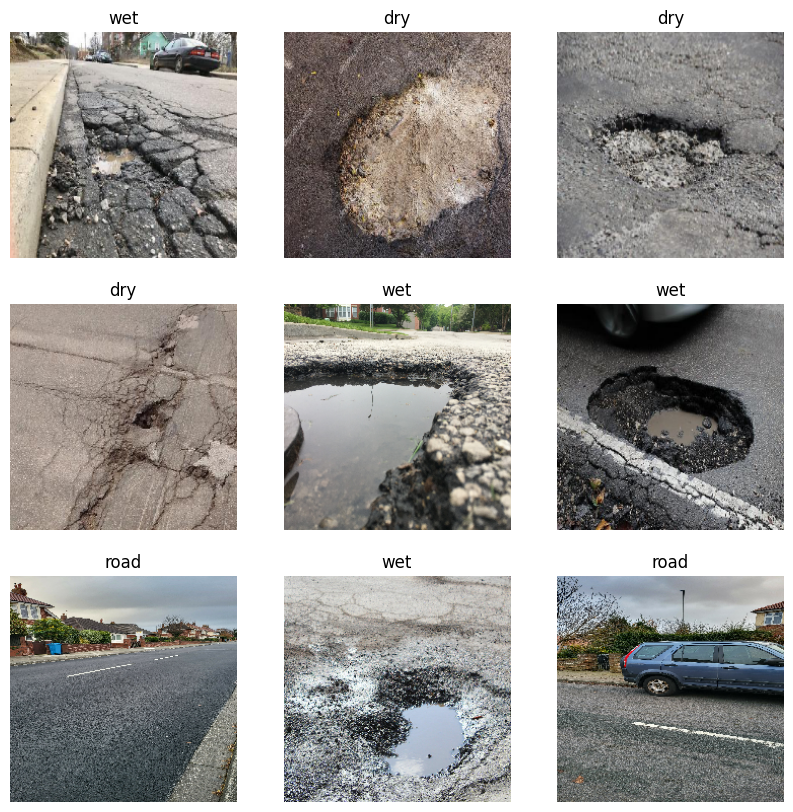

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

This line is downloading a file named ‘ImageNetLabels.txt’ from a URL and saving it to a local file path. This file contains the names of the classes that the pre-trained model was originally trained to recognize.

In [ ]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

10484/10484 [==============================] - 0s 0us/step


This to create a runtime tunning to the values of the data concurrently to prepare the next data for processing, while the current data is being proessed.THis is done for both validation and training sets.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# **DATA PREPROCESSING**

This creates a data argumention that flips and rotates the the images of the datset horizonatally to foster generalization of the model

In [ ]:

#Flips horizonatally and rotates by 20% of 360 degree random images in the dataset

# augmentation = tf.keras.Sequential([
#   tf.keras.layers.RandomFlip('horizontal'),
#   tf.keras.layers.RandomRotation(0.2),
#   tf.keras.layers.RandomContrast(0.2)
# ])

In [ ]:
# for image, _ in train_dataset.take(10):
#   plt.figure(figsize=(10, 10))
#   first_image = image[0]
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     augmented_image = augmentation(tf.expand_dims(first_image, 0))
#     plt.imshow(augmented_image[0] / 255)
#     plt.axis('off')

Rescalling is done on the dataset as a form of data augmentation to scale pixel values of the images of the images from a range of 0-255 with an off set at a range of 0-1

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

Prints out the number images and dimensions in each batch the model will iterate till the training of the model is done

In [ ]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


This prints out the total batch each iteration of images will do perform a prediction. It stores the prediction in the result batch.

In [ ]:
result_batch = classifier.predict(train_dataset)

19/19 [==============================] - 26s 944ms/step


This will generate the corresponding class label of the dataset that was inputed using imagenet net label and stores in the predicted_class_names

In [ ]:
predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]
predicted_class_names

array(['stone wall', 'sandbar', 'racer', 'volcano', 'mailbox',
       'park bench', 'dam', 'leatherback turtle', 'park bench', 'pole',
       'leatherback turtle', 'volcano', 'pole', 'car wheel', 'sports car',
       'face powder', 'breakwater', 'barn spider', 'horned viper',
       'sandbar', 'volcano', 'hammerhead', 'seashore', 'sea cucumber',
       'jeep', 'sports car', 'whiptail', 'switch', 'electric ray',
       'leatherback turtle', 'breakwater', 'streetcar', 'sundial',
       'car wheel', 'minivan', 'parachute', 'stone wall', 'breakwater',
       'car wheel', 'car wheel', 'worm fence', 'sandbar', 'garbage truck',
       'seashore', 'leatherback turtle', 'breakwater', 'mobile home',
       'moving van', 'geyser', 'tick', 'car wheel', 'leatherback turtle',
       'breakwater', 'sea cucumber', 'megalith', 'volcano', 'trilobite',
       'minivan', 'minivan', 'suspension bridge', 'park bench',
       'dung beetle', 'breakwater', 'face powder', 'leatherback turtle',
       'moped', '

This plots the images along side their imagenet prediction lables



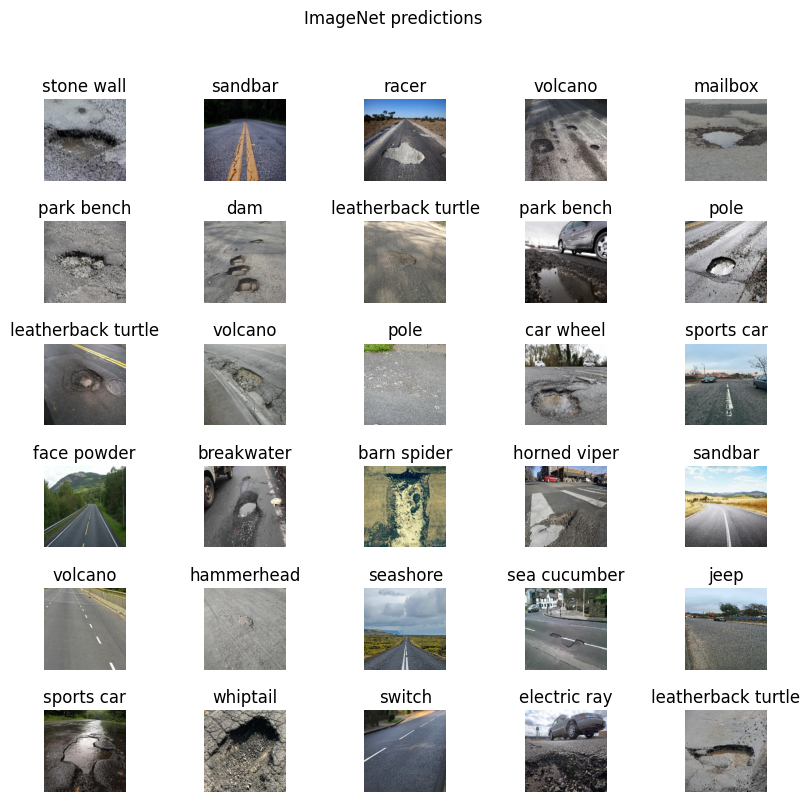

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [ ]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v2 #@param ["mobilenet_v2", "inception_v3"] {type:"raw"}

In [ ]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [ ]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


This determines the parameters of the model architecture.
Tensorflow Api for binary class is added. vectorization of image and a dense layer the same number of classes of the dataset is added.

In [ ]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  #augmentation,
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes),
  Dropout(0.5),
])

This genrates a predictions for each image in the image_batch and stores in predictions

In [ ]:
predictions = model(image_batch)

Shows the number of images in a batch as well as the number of classes that were processed.

In [ ]:
predictions.shape

TensorShape([32, 3])

This prepares the model for training; the adam optimizer is used because adjusts learning rates for each parameter individually, accommodating both high and low-gradient parameters.

Binary Cross entrophy is a loss function commionly used for binary classification that tracks incorrect labeling of the data class by a model, penalizing the model if changes in probability occur into classifying the labels

logits= true assumes all model output values are not probailites



---

The tensor board directory is where logs are saved with the current date and time. The tensorboard call back uses the log files saved to visualize the training and evaluation metrics where the the value of 1 means a visualiztion for every completed epoch.








In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
 dropout (Dropout)           (None, 3)                 0         
                                                                 
Total params: 2261827 (8.63 MB)
Trainable params: 3843 (15.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

Epochs are the number of iterations the model will do to train the datasets

history records the training loss,  metrics values as well as validation loss and metrics at each epoch  

In [ ]:
NUM_EPOCHS = 20

history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/20
19/19 [==============================] - 38s 2s/step - loss: 1.1056 - acc: 0.4817 - val_loss: 0.5051 - val_acc: 0.8250
Epoch 2/20
19/19 [==============================] - 28s 1s/step - loss: 0.7406 - acc: 0.6217 - val_loss: 0.3494 - val_acc: 0.9083
Epoch 3/20
19/19 [==============================] - 33s 2s/step - loss: 0.6030 - acc: 0.6817 - val_loss: 0.2896 - val_acc: 0.9083
Epoch 4/20
19/19 [==============================] - 33s 2s/step - loss: 0.5865 - acc: 0.6983 - val_loss: 0.2541 - val_acc: 0.9250
Epoch 5/20
19/19 [==============================] - 33s 2s/step - loss: 0.5076 - acc: 0.7033 - val_loss: 0.2307 - val_acc: 0.9250
Epoch 6/20
19/19 [==============================] - 31s 2s/step - loss: 0.4811 - acc: 0.7433 - val_loss: 0.1906 - val_acc: 0.9583
Epoch 7/20
19/19 [==============================] - 36s 2s/step - loss: 0.4625 - acc: 0.7400 - val_loss: 0.2110 - val_acc: 0.9250
Epoch 8/20
19/19 [==============================] - 30s 2s/step - loss: 0.4926 - acc: 0.72

The Tensorboard provides the visualization and tools needed for maching learning using the logs created earlier during the training of the model.

In [ ]:
%tensorboard --logdir logs/fit

<IPython.core.display.Javascript object>

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

1/1 [==============================] - 1s 1s/step
['wet' 'dry' 'road' 'wet' 'road' 'dry' 'road' 'wet' 'road' 'wet' 'dry'
 'dry' 'wet' 'dry' 'road' 'wet' 'dry' 'dry' 'road' 'dry' 'road' 'dry'
 'dry' 'wet' 'wet' 'road' 'road' 'dry' 'road' 'road' 'wet' 'wet']


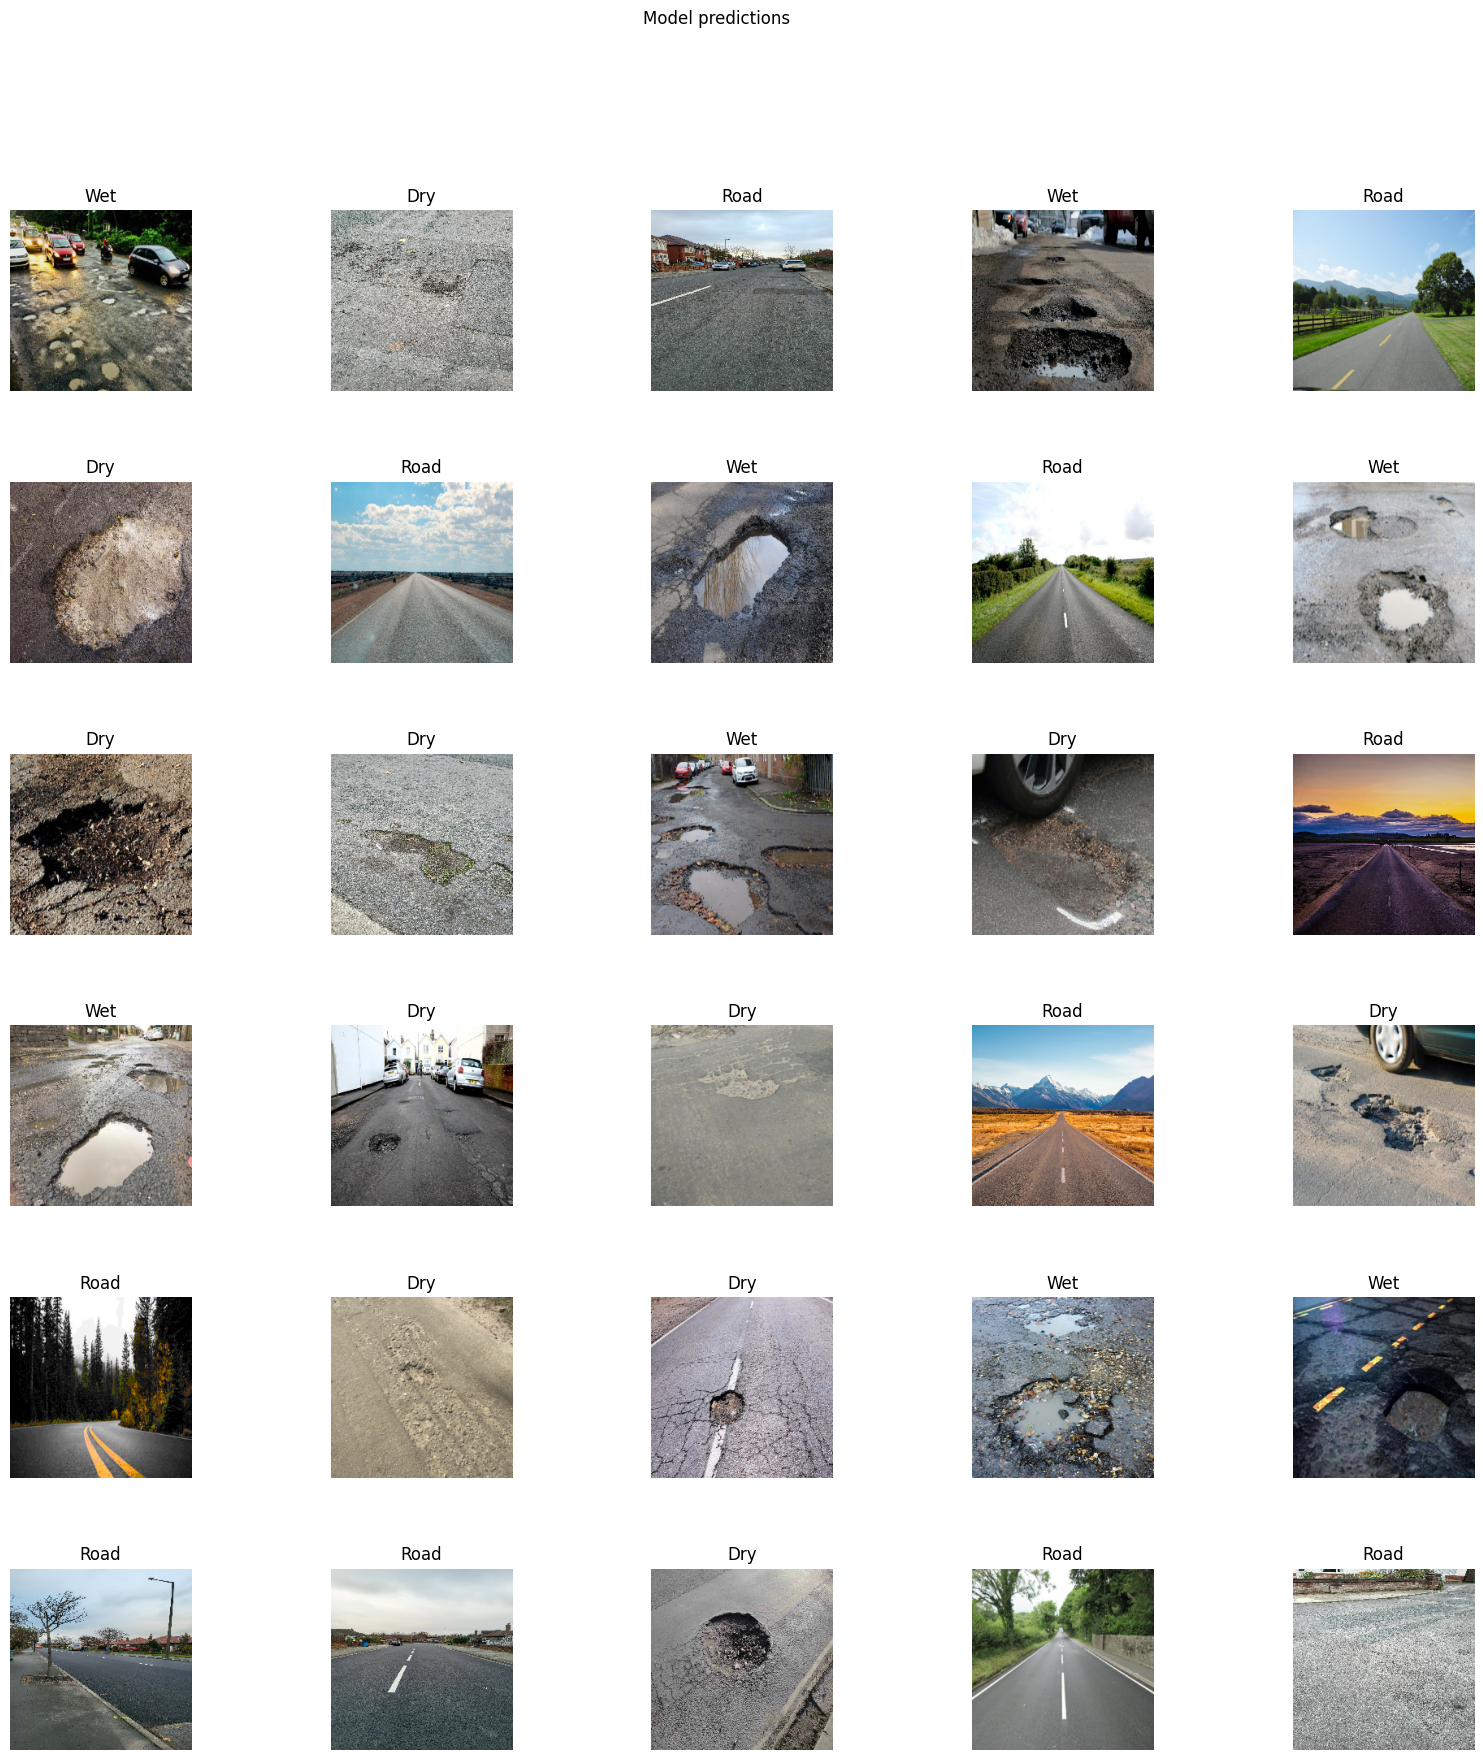

In [ ]:
plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

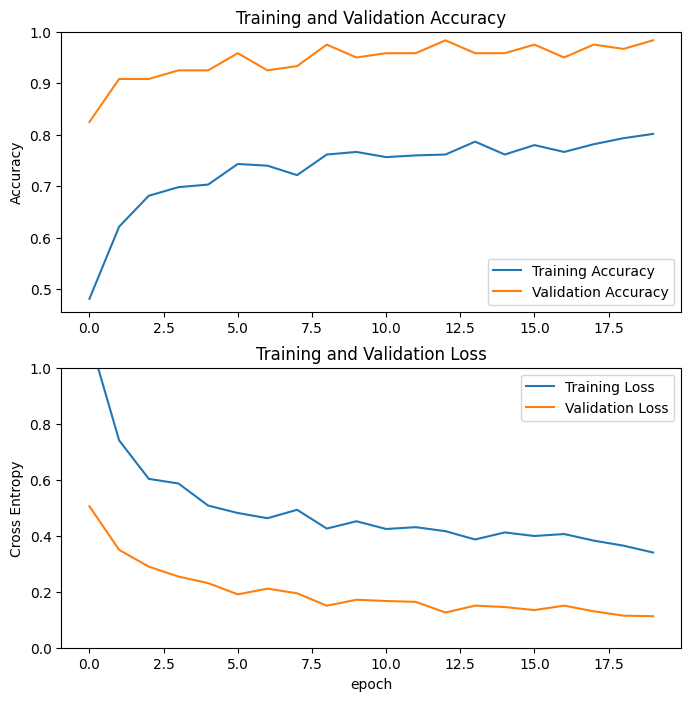

In [ ]:
accuracy = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

4/4 [==============================] - 7s 1s/step
[[40  0  0]
 [ 0 40  0]
 [ 2  0 38]]


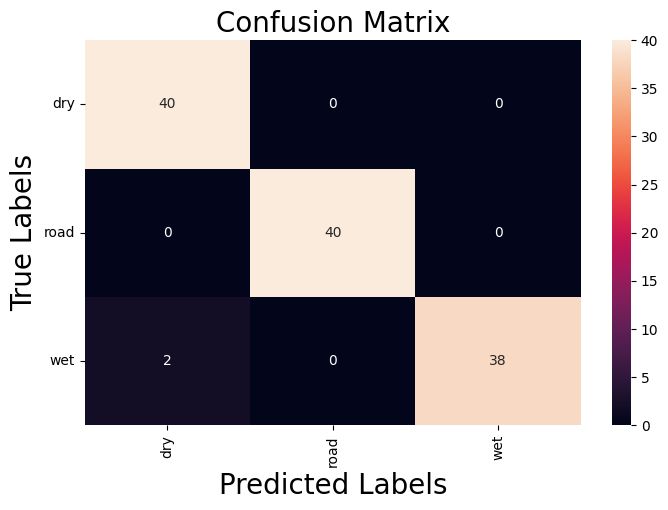

In [ ]:
# Extract images from the validation dataset
validation_images = validation_dataset.map(lambda x, y: x)

# Use the model to make predictions
y_pred = model.predict(validation_images)
y_pred = np.argmax(y_pred, axis=1)

# Get the true labels
y_true = np.concatenate([y for x, y in validation_dataset])

# Compute the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Your labels
labels = class_names

# Plot the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(8, 5))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt='g')
ax.set_xlabel('Predicted Labels', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(labels, fontsize=10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True Labels', fontsize=20)
ax.yaxis.set_ticklabels(labels, fontsize=10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix', fontsize=20)
plt.savefig('ConMat24.png')
plt.show()


In [ ]:
loss, acc = model.evaluate(validation_dataset)
print('Test accuracy :', acc)

4/4 [==============================] - 4s 907ms/step - loss: 0.1126 - acc: 0.9833
Test accuracy : 0.9833333492279053


Classification report

In [ ]:
from sklearn.metrics import classification_report

from sklearn.metrics import balanced_accuracy_score

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        40
           1       1.00      1.00      1.00        40
           2       1.00      0.95      0.97        40

    accuracy                           0.98       120
   macro avg       0.98      0.98      0.98       120
weighted avg       0.98      0.98      0.98       120



In [ ]:
#Evaluate Model
# calculate and print  Classifiers' Accuracies
print("Accuracy:", accuracy_score(y_true, y_pred))

Accuracy: 0.9833333333333333


In [ ]:
# Calculate precision, recall, and F1 score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Accuracy: 0.9833
Precision: 0.9841
Recall: 0.9833
F1 Score: 0.9833


In [ ]:
save_path = '/content/model.h5'

# Save the model
model.save(save_path)

print(f"Model saved as {save_path}")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as /content/model.h5


In [ ]:
from google.colab import files
upload = files.upload()